In [1]:
#Import Packages
import os
import pandas as pd
import numpy as np

#Change Working Directory
os.chdir(r'C:\Users\malva\Thesis')

#Read data file
data = pd.read_csv('Files\Samples\ValdAran_Sample.csv')
data.head()

,lat,long,elevation,slope,aspect,curv_plan,curv_prof,facc,twi,soil,lulc,rain_ant,rain_event,pof_event,pof_dry,pof_sat,response
0,4738872.5,311597.5,790.80,13.145604,327.05750,0.025769,-0.010359,1.397940,4.673251,2.0,3.0,0.5,49.0,0.0000,0.0000,1.0000,1.0
1,4738862.5,311617.5,794.77,18.441340,307.93506,-0.117006,-0.044545,2.352183,6.514342,2.0,3.0,0.5,49.0,0.0000,0.0000,1.0000,1.0
2,4738697.5,319872.5,1709.36,43.968290,173.81042,0.000644,0.018706,2.889302,6.688886,8.0,1.0,0.5,70.0,0.8803,0.3543,0.1197,1.0
3,4737832.5,318912.5,1285.22,47.644943,194.89754,0.076285,0.069331,0.000000,-11.605381,8.0,1.0,0.5,69.0,0.6894,0.5387,0.1381,1.0
4,4737377.5,317017.5,1734.32,39.489166,182.85223,-0.000287,-0.003942,3.122216,7.382731,8.0,1.0,0.5,67.0,0.6695,0.0711,0.3305,1.0


In [2]:
print('Soil: ' + str(sorted(data['soil'].unique())))
print('LULC: ' + str(sorted(data['lulc'].unique())))

Soil: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
LULC: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 9.0]


In [3]:
#Encoding Categorical with Pandas
X = pd.get_dummies(data, columns = ['soil', 'lulc'])
X = X.drop(columns=['lat', 'long', 'elevation', 'pof_event', 'pof_dry', 'pof_sat', 'response'])

In [4]:
#Complete missing columns
X['lulc_7.0'] = 0
X['lulc_10.0'] = 0
X.sort_index(axis=1, inplace=True)
X.columns

Index(['aspect', 'curv_plan', 'curv_prof', 'facc', 'lulc_1.0', 'lulc_10.0',
       'lulc_2.0', 'lulc_3.0', 'lulc_4.0', 'lulc_5.0', 'lulc_6.0', 'lulc_7.0',
       'lulc_8.0', 'lulc_9.0', 'rain_ant', 'rain_event', 'slope', 'soil_1.0',
       'soil_10.0', 'soil_11.0', 'soil_2.0', 'soil_3.0', 'soil_4.0',
       'soil_5.0', 'soil_6.0', 'soil_7.0', 'soil_8.0', 'soil_9.0', 'twi'],
      dtype='object')

In [5]:
#Create inputs and outputs for the data-driven model
y = data['response'].values

In [6]:
# Split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [7]:
#Logistic Regression with Cross-validation (5-fold) and parameter optimization
#No Rainfall

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 

logreg_norain = LogisticRegression()
param_grid = {'max_iter' : [2500],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}
clf_norain = GridSearchCV(logreg_norain, param_grid = param_grid, scoring = 'roc_auc', n_jobs = -1, cv = 5)
best_logreg_norain = clf_norain.fit(X_train.drop(columns=['rain_ant', 'rain_event']), y_train)

results_norain = pd.DataFrame(clf_norain.cv_results_)
print('Best Score: ' + str(best_logreg_norain.best_score_))
print('Best Parameters: ' + str(best_logreg_norain.best_params_))

Best Score: 0.780758600877671
Best Parameters: {'C': 0.615848211066026, 'max_iter': 2500, 'penalty': 'l1', 'solver': 'liblinear'}


In [8]:
#Logistic Regression with Cross-validation (5-fold) and parameter optimization
#Rainfall

logreg_rain = LogisticRegression()
clf_rain = GridSearchCV(logreg_rain, param_grid = param_grid, scoring = 'roc_auc', n_jobs = -1, cv = 5)
best_logreg_rain = clf_rain.fit(X_train, y_train)

results_rain = pd.DataFrame(clf_rain.cv_results_)
print('Best Score: ' + str(best_logreg_rain.best_score_))
print('Best Parameters: ' + str(best_logreg_rain.best_params_))

Best Score: 0.7940029123616876
Best Parameters: {'C': 29.763514416313132, 'max_iter': 2500, 'penalty': 'l1', 'solver': 'liblinear'}


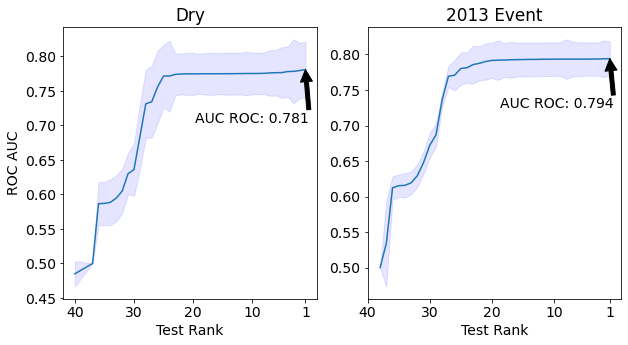

In [10]:
#Training Plots
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
xtickslabels = [40, 30, 20, 10, 1]

#No Rain
results_norain.sort_values(by=['rank_test_score'], inplace=True)
test_scores = results_norain['mean_test_score']
test_ranks = results_norain['rank_test_score']
test_error = results_norain['std_test_score']

ax[0].plot(test_ranks, test_scores)
ax[0].fill_between(test_ranks, test_scores-test_error, test_scores+test_error, color='b', alpha=.1)
ax[0].annotate(text = "AUC ROC: " + str(round(results_norain['mean_test_score'].max(),3)),
             xy = (1, results_norain['mean_test_score'].max()),
             xytext=(0.4, 0.72),arrowprops=dict(facecolor='black'),
            horizontalalignment='right', verticalalignment='top')
ax[0].invert_xaxis()
ax[0].set_title('Dry')
ax[0].set_xlabel('Test Rank')
ax[0].set_xticks(xtickslabels)
ax[0].set_ylabel('ROC AUC')

#Rain
results_rain.sort_values(by=['rank_test_score'], inplace=True)
test_scores = results_rain['mean_test_score']
test_ranks = results_rain['rank_test_score']
test_error = results_rain['std_test_score']

ax[1].plot(test_ranks, test_scores)
ax[1].fill_between(test_ranks, test_scores-test_error, test_scores+test_error, color='b', alpha=.1)
ax[1].annotate(text = "AUC ROC: " + str(round(results_rain['mean_test_score'].max(),3)),
             xy = (1, results_rain['mean_test_score'].max()),
             xytext=(0.4, 0.74),arrowprops=dict(facecolor='black'),
            horizontalalignment='right', verticalalignment='top')
ax[1].invert_xaxis()
ax[1].set_xticks(xtickslabels)
ax[1].set_title('2013 Event')
ax[1].set_xlabel('Test Rank')

plt.savefig(r'C:\Users\malva\Desktop\Test\traininglogistic.png', dpi=300)
plt.show()

In [11]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

#Logistic Regression

#No Rainfall
y_pred_prob_norain = best_logreg_norain.predict_proba(X_test.drop(columns=['rain_ant', 'rain_event']))[:, 1]

fpr_norain, tpr_norain, thresholds_norain = metrics.roc_curve(y_test, y_pred_prob_norain)
auc_norain = metrics.roc_auc_score(y_test, y_pred_prob_norain)

#Rainfall
y_pred_prob_rain = best_logreg_rain.predict_proba(X_test)[:, 1]

fpr_rain, tpr_rain, thresholds_rain = metrics.roc_curve(y_test, y_pred_prob_rain)
auc_rain = metrics.roc_auc_score(y_test, y_pred_prob_rain)

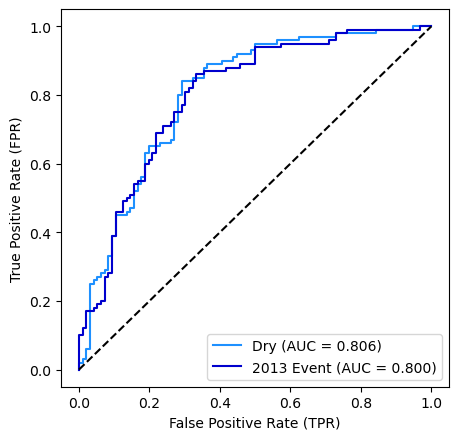

In [12]:
#Plot the ROC curve and calculate AUC
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(fpr_norain, tpr_norain, marker='', color='dodgerblue', label='Dry (AUC = %0.3f)' % auc_norain)
plt.plot(fpr_rain, tpr_rain, marker='', color='mediumblue', label='2013 Event (AUC = %0.3f)' % auc_rain)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (TPR)')
plt.ylabel('True Positive Rate (FPR)')
plt.legend()
plt.savefig(r'C:\Users\malva\Desktop\Test\roclogistic.png', dpi=300)
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, matthews_corrcoef

#No Rain
y_pred_norain = best_logreg_norain.predict(X_test.drop(columns=['rain_ant', 'rain_event']))
matrix_norain = confusion_matrix(y_test, y_pred_norain)
acc_norain = accuracy_score(y_test, y_pred_norain)
FP = matrix_norain[0,1]
TN = matrix_norain[0,0]
fpr_norain = FP/(FP+TN)
fnr_norain = 1 - recall_score(y_test, y_pred_norain)
mcc_norain = matthews_corrcoef(y_test, y_pred_norain)
stats_norain = '\n\nAccuracy = {:0.3f}\nFPR = {:0.3f}\nFNR = {:0.3f}\nMCC = {:0.3f}'.format(acc_norain, fpr_norain, fnr_norain, mcc_norain)


#No Rain
y_pred_rain = best_logreg_rain.predict(X_test)
matrix_rain = confusion_matrix(y_test, y_pred_rain)
acc_rain = accuracy_score(y_test, y_pred_rain)
FP = matrix_rain[0,1]
TN = matrix_rain[0,0]
fpr_rain = FP/(FP+TN)
fnr_rain = 1 - recall_score(y_test, y_pred_rain)
mcc_rain = matthews_corrcoef(y_test, y_pred_rain)
stats_rain = '\n\nAccuracy = {:0.3f}\nFPR = {:0.3f}\nFNR = {:0.3f}\nMCC = {:0.3f}'.format(acc_rain, fpr_rain, fnr_rain, mcc_rain)

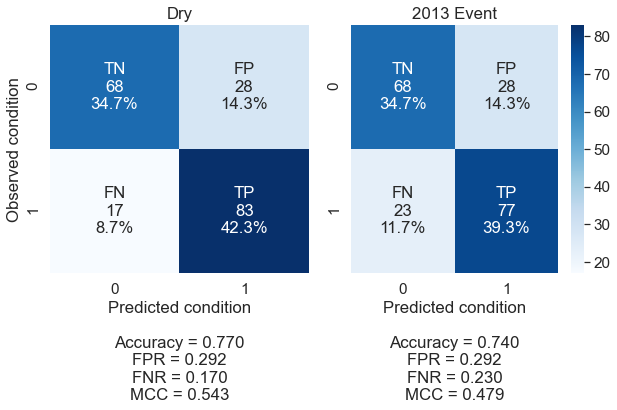

In [14]:
import seaborn as sns

sns.set(font_scale=1.4)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))

low_lim = np.min(np.concatenate((matrix_norain, matrix_rain)))
upp_lim = np.max(np.concatenate((matrix_norain, matrix_rain)))

#Heatmap No Rain
group_names = ['TN', 'FP','FN', 'TP']
group_counts = ['{0:0.0f}'.format(value) for value in matrix_norain.flatten()]
group_percentages = ['{0:.1%}'.format(value) for value in matrix_norain.flatten()/np.sum(matrix_norain)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix_norain, vmin=low_lim, vmax=upp_lim, annot=labels, fmt='', cbar=False, cmap='Blues', ax=ax[0])

#Heatmap Rain
group_counts = ['{0:0.0f}'.format(value) for value in matrix_rain.flatten()]
group_percentages = ['{0:.1%}'.format(value) for value in matrix_rain.flatten()/np.sum(matrix_rain)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix_rain, vmin=low_lim, vmax=upp_lim, annot=labels, fmt='', cbar=True, cmap='Blues', ax=ax[1])

ax[0].set_title('Dry')
ax[1].set_title('2013 Event')
ax[0].set_ylabel('Observed condition')
ax[0].set_xlabel('Predicted condition' + stats_norain)
ax[1].set_xlabel('Predicted condition' + stats_rain)
plt.tight_layout()
plt.savefig(r'C:\Users\malva\Desktop\Test\confusionlogistic.png', dpi=300)
plt.show()

In [15]:
#Save models as Pickles
import pickle

pkl_filename = 'Files\Models\logreg_norain.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_logreg_norain, file)
    
pkl_filename = 'Files\Models\logreg_rain.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(best_logreg_rain, file)

In [16]:
#P-values - No Rain
from sklearn.model_selection import cross_validate

clf = LogisticRegression(penalty = 'l1', C = 0.615848211066026, solver = 'liblinear', max_iter = 2500)
cv_results_norain = cross_validate(clf, X_train.drop(columns=['rain_ant', 'rain_event']), y_train, cv=100, return_estimator=True)

In [17]:
#P-values - Rain
clf = LogisticRegression(penalty = 'l1', C = 29.763514416313132, solver = 'liblinear', max_iter = 2500)
cv_results_rain = cross_validate(clf, X_train, y_train, cv=100, return_estimator=True)

In [18]:
df_coef_norain = pd.DataFrame(columns = X_train.drop(columns=['rain_ant', 'rain_event']).columns)
df_coef_rain = pd.DataFrame(columns = X_train.columns)

i = 1
for model in cv_results_norain['estimator']:
    df_coef_norain.loc['Model' + str(i)] = model.coef_.ravel()
    i += 1
    
i = 1
for model in cv_results_rain['estimator']:
    df_coef_rain.loc['Model' + str(i)] = model.coef_.ravel()
    i += 1

In [19]:
import scipy

results_df_norain = pd.DataFrame()

results_df_norain['mean'] = df_coef_norain.describe().loc['mean']
results_df_norain['std'] = df_coef_norain.describe().loc['std']
results_df_norain['z-scores'] = results_df_norain['mean']/results_df_norain['std']

p_values = 1 - scipy.stats.norm.cdf(abs(results_df_norain['z-scores']))
results_df_norain['p-values'] = np.round(p_values, 5)
results_df_norain.sort_values(by='z-scores', ascending=False, inplace=True, key=abs)

In [20]:
print(results_df_norain.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &      mean &       std &   z-scores &  p-values \\
\midrule
soil\_7.0  &  1.067389 &  0.023103 &  46.200633 &   0.00000 \\
slope     &  0.048419 &  0.001102 &  43.938897 &   0.00000 \\
lulc\_1.0  & -1.001247 &  0.027582 & -36.301225 &   0.00000 \\
soil\_9.0  & -1.504870 &  0.045766 & -32.881746 &   0.00000 \\
lulc\_3.0  &  0.518149 &  0.022579 &  22.947993 &   0.00000 \\
soil\_4.0  & -1.092250 &  0.059078 & -18.488382 &   0.00000 \\
soil\_2.0  &  0.430259 &  0.031416 &  13.695688 &   0.00000 \\
soil\_6.0  &  0.225267 &  0.033074 &   6.811038 &   0.00000 \\
soil\_5.0  & -0.285078 &  0.082727 &  -3.446019 &   0.00028 \\
aspect    & -0.000239 &  0.000096 &  -2.487967 &   0.00642 \\
facc      & -0.035758 &  0.017691 &  -2.021212 &   0.02163 \\
soil\_1.0  & -0.044889 &  0.056727 &  -0.791310 &   0.21438 \\
twi       &  0.001727 &  0.002815 &   0.613654 &   0.26972 \\
soil\_10.0 & -0.001466 &  0.011650 &  -0.125793 &   0.44995 \\
curv\_plan &  0.000000 &  

In [21]:
results_df_rain = pd.DataFrame()

results_df_rain['mean'] = np.round(df_coef_rain.describe().loc['mean'], 5)
results_df_rain['std'] = np.round(df_coef_rain.describe().loc['std'], 5)
results_df_rain['z-scores'] = np.round(results_df_rain['mean']/results_df_rain['std'], 5)

p_values = 1 - scipy.stats.norm.cdf(abs(results_df_rain['z-scores']))
results_df_rain['p-values'] = np.round(p_values, 5)
results_df_rain.sort_values(by='z-scores', ascending=False, inplace=True, key=abs)

In [22]:
print(results_df_rain.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &     mean &      std &  z-scores &  p-values \\
\midrule
slope      &  0.04916 &  0.00116 &  42.37931 &   0.00000 \\
lulc\_8.0   & -4.54165 &  0.10751 & -42.24398 &   0.00000 \\
lulc\_1.0   & -1.45208 &  0.04052 & -35.83613 &   0.00000 \\
rain\_ant   & -3.73626 &  0.11552 & -32.34297 &   0.00000 \\
lulc\_4.0   &  3.35991 &  0.10415 &  32.26030 &   0.00000 \\
soil\_7.0   &  0.93739 &  0.02970 &  31.56195 &   0.00000 \\
soil\_9.0   & -1.91144 &  0.06092 & -31.37623 &   0.00000 \\
rain\_event &  0.01609 &  0.00079 &  20.36709 &   0.00000 \\
soil\_4.0   & -1.43915 &  0.07382 & -19.49539 &   0.00000 \\
lulc\_3.0   &  0.59242 &  0.04244 &  13.95900 &   0.00000 \\
soil\_2.0   &  0.47039 &  0.03655 &  12.86977 &   0.00000 \\
soil\_10.0  & -1.01274 &  0.09358 & -10.82218 &   0.00000 \\
soil\_6.0   &  0.41257 &  0.03926 &  10.50866 &   0.00000 \\
soil\_11.0  &  0.58145 &  0.06111 &   9.51481 &   0.00000 \\
soil\_3.0   & -1.88062 &  0.19941 &  -9.43092 &   0.00